In [1]:
import numpy as np
import stim

In [9]:
def binary_np_array_to_str(arr: np.ndarray) -> str:
    """Convert a binary numpy array (one-dimensional) to a string,
    e.g. [True, False, True] -> '101'."""

    assert len(arr.shape) == 1
    return ''.join('1' if b else '0' for b in arr)

In [10]:
assert binary_np_array_to_str(np.array([True, False, True])) == "101"

# Detector error models

## A Bell state

Consider the state

$\ket{\Psi} = \frac{1}{\sqrt{2}} (\ket{00} + \ket{11})$.

If we measure this state in the computational basis, we will get either $00$ or $11$ with equal probability. Both of these measurement results are of even parity, i.e. $0 \oplus 0 = 0$, $1 \oplus 1 = 0$. Let's test this out in `stim`.

In [6]:
bell_ckt = stim.Circuit()
bell_ckt.append("H", 0)
bell_ckt.append("CX", [0, 1])
bell_ckt.append("M", [0, 1])
print(bell_ckt)

H 0
CX 0 1
M 0 1


In [15]:
sampler = bell_ckt.compile_sampler()
results = sampler.sample(10)
for bitstr in results:
    # We can take the XOR of a binary vector by doing a sum mod 2.
    print(binary_np_array_to_str(bitstr), np.sum(bitstr) % 2)

00 0
00 0
11 0
11 0
11 0
00 0
00 0
00 0
00 0
11 0


Now let's try the same thing, except there is some bit-flip noise after we prepare the state and before we measure. In this case, there is some probability that we will measure a bitstring like $01$ or $10$. Note that $0 \oplus 1 = 1 \oplus 0 = 1$. When there is no noise, we expect that taking the XOR of all measured bits will result in $0$, and that noise gives a probability to get $1$ for the XOR instead.

In [18]:
noisy_bell_ckt = stim.Circuit()
noisy_bell_ckt.append("H", 0)
noisy_bell_ckt.append("CX", [0, 1])
noisy_bell_ckt.append("X_ERROR", [0, 1], arg=0.1)
noisy_bell_ckt.append("M", [0, 1])
print(noisy_bell_ckt)

H 0
CX 0 1
X_ERROR(0.1) 0 1
M 0 1


In [21]:
sampler = noisy_bell_ckt.compile_sampler()
shots = 100
results = sampler.sample(shots)
num_not_false = 0
for bitstr in results:
    xor = np.sum(bitstr) % 2
    if xor:
        num_not_false += 1
    print(binary_np_array_to_str(bitstr), xor)

print(f"{num_not_false}/{shots} XORs were True.")

00 0
00 0
11 0
00 0
10 1
01 1
11 0
00 0
00 0
10 1
00 0
11 0
00 0
11 0
00 0
11 0
00 0
11 0
00 0
11 0
01 1
11 0
01 1
00 0
00 0
00 0
00 0
00 0
11 0
00 0
00 0
01 1
00 0
11 0
11 0
11 0
11 0
00 0
11 0
00 0
11 0
11 0
11 0
10 1
11 0
00 0
11 0
11 0
11 0
00 0
00 0
11 0
10 1
01 1
01 1
00 0
00 0
11 0
01 1
00 0
11 0
01 1
10 1
11 0
11 0
00 0
00 0
00 0
11 0
00 0
00 0
11 0
11 0
10 1
01 1
00 0
11 0
11 0
11 0
10 1
00 0
11 0
00 0
11 0
11 0
00 0
00 0
00 0
00 0
00 0
00 0
11 0
11 0
01 1
01 1
11 0
00 0
00 0
00 0
00 0
18/100 XORs were True.


Taking the XOR tells us whether certain measurement results are the same as we would expect from a noiseless circuit. A _detector error model_ formalizes this concept. A detector is a set of measurements made in a circuit. When there is no noise in the circuit, the XOR of those bits is guaranteed to be $0$. In the presence of noise, the XOR of the bits can be $1$. A detector error model is a set of detectors pretaining to a circuit. If a certain detector returns $1$ for some shot of a circuit, we say that that detector "flipped."

In `stim`, detector error models can be built directly into a quantum circuit. An example of a detector instruction in `stim` looks like `DETECTOR rec[-1] rec[-2]`. Thik of `rec` is an array of measurement resuolts. `DETECTOR rec[-1] rec[-2]`, then, indicates that the detector consists of the XOR of the last two measurements. We can also XOR measurements that aren't consecutive, such as `DETECTOR rec[-2] rec[-4] rec[-6]`. When we sample from a detector error model, we get one bit for each detector. In our example, the detector error consists of the two measurements at the end of the circuit. Let's try circuit both with and without noise and see what the detector error model gives.

In [34]:
def bell_dem_circuit(noise_level: float) -> stim.Circuit:
    """Generates a Bell state circuit with noise after the state prep and two measurements.
    The measurements are used as a detector."""

    if noise_level > 1. or noise_level < 0.:
        raise ValueError(f"Noise level must be between 0 and 1, but got {noise_level}.")

    ckt = stim.Circuit()
    ckt.append("H", 0)
    ckt.append("CX", [0, 1])
    ckt.append("X_ERROR", [0, 1], arg=noise_level)
    ckt.append("M", [0, 1])
    ckt.append_from_stim_program_text("DETECTOR rec[-1] rec[-2]")
    return ckt

In [35]:
noiseless_ckt = bell_dem_circuit(0.)
print(noiseless_ckt)

dem_sampler = noiseless_ckt.compile_detector_sampler()
shots = 100
results = dem_sampler.sample(shots)
num_true = 0
for result in results:
    if result[0]:
        print('1')
        num_true += 1
    else:
        print('0')
print(f"{num_true} detectors flipped.")

H 0
CX 0 1
X_ERROR(0) 0 1
M 0 1
DETECTOR rec[-1] rec[-2]
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0 detectors flipped.


In [36]:
noiseless_ckt = bell_dem_circuit(0.3)
print(noiseless_ckt)

dem_sampler = noiseless_ckt.compile_detector_sampler()
shots = 100
results = dem_sampler.sample(shots)
num_true = 0
for result in results:
    if result[0]:
        print('1')
        num_true += 1
    else:
        print('0')
print(f"{num_true} detectors flipped.")

H 0
CX 0 1
X_ERROR(0.3) 0 1
M 0 1
DETECTOR rec[-1] rec[-2]
0
0
1
0
1
0
0
0
0
0
0
1
0
0
0
1
0
0
1
1
1
1
1
0
0
1
1
1
0
0
0
0
1
0
0
0
1
1
0
0
1
0
0
0
0
0
1
1
1
0
1
0
1
1
0
0
0
1
1
0
0
1
0
0
0
1
1
0
0
0
1
0
0
0
1
1
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
1
1
0
0
1
0
0
1
1
36 detectors flipped.


## The repetition code

When our circuits have special structure, detector error models give concise descriptions of what properties sets of measurements should have. Luckily for us, quantum error correction is all about taking the XOR of measurements! As a reminder, let's think about the quantum repetition code with $d=3$. The check matrix is

$\begin{bmatrix}1 & 1 & 0 \\0 & 1 & 1\\ \end{bmatrix}$

In a phenomenological error model, noise is applied to all qubits (both code qubits and syndrome qubits) before each round of syndrome extraction. When there is noise on the syndrome qubits, multiple rounds of syndrome extraction can be used to get better information about the errors that have occured on the data qubits. For each round of syndrome extraction, the repetition code gadget gives a $(d-1)$-bit syndrome.

Suppose we do $r$ rounds of syndrome extraction from a distance-$d$ repetition code, yielding a syndrome (or set of syndromes) with $r(d-1)$ bits. First consider the case where there is no noise. This case gives the syndrome $00\ldots00$. If we reshape the syndrome into a $r \times d-1$ binary matrix called $S$, note that we can XOR each column togther. Now let's think about a case where an error occurs. Fix $d=3$ and $r=4$. The error will occur on the first qubit before the second round. For each consecutive pair of rounds and each syndrome bit, our DEM will measure whether $S_{i,k} = S_{i+1,k}$.

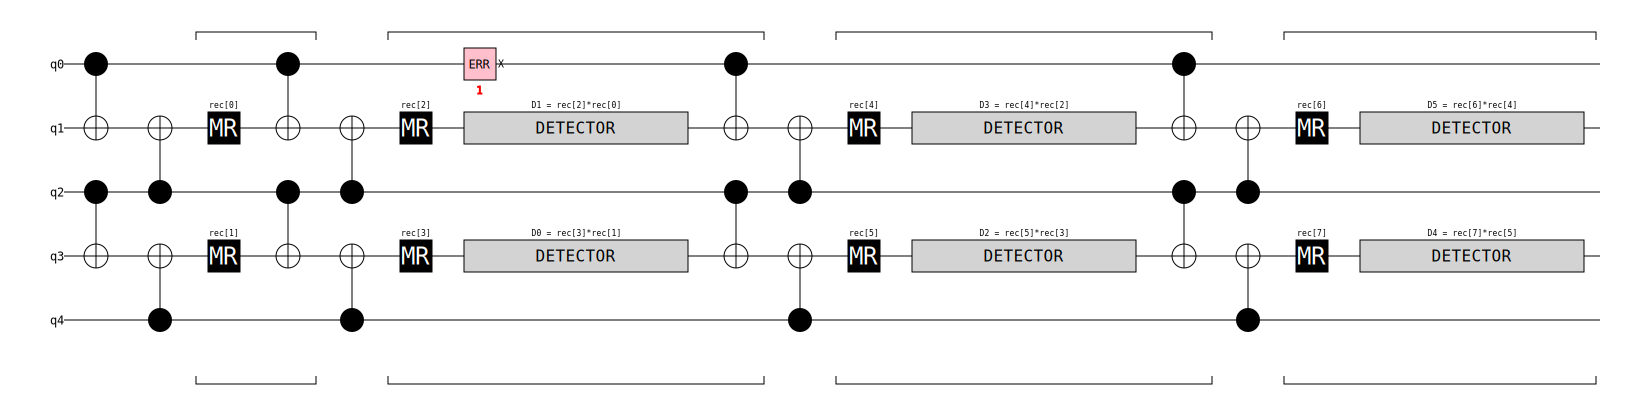

In [83]:
d = 3
r = 4
data_qubits = list(range(0, 2 * d, 2))
measure_qubits = list(range(1, 2 * d - 1, 2))

# Make the check circuit.
check_ckt = stim.Circuit()
measure_targets = []
for mq in measure_qubits:
    measure_targets += [mq-1, mq]
check_ckt.append("CX", measure_targets)
check_ckt.append("TICK")
measure_targets = []
for mq in measure_qubits:
    measure_targets += [mq+1, mq]
check_ckt.append("CX", measure_targets)
check_ckt.append("TICK")
check_ckt.append("MR", measure_qubits)

detector_ckt = stim.Circuit()
for i in range(len(measure_qubits)):
    detector_ckt.append_from_stim_program_text(
        f"DETECTOR rec[{-1-i}] rec[{-1-i-len(measure_qubits)}]"
    )

ckt = stim.Circuit()
ckt += check_ckt
# ckt.append_from_stim_program_text(
#     "DETECTOR rec[-1]"
# )
# ckt.append_from_stim_program_text(
#     "DETECTOR rec[-2]"
# )
ckt += check_ckt
ckt += detector_ckt
# Inject the error.
ckt.append("X_ERROR", 0, arg=1.0)
ckt += check_ckt
ckt += detector_ckt
ckt += check_ckt
ckt += detector_ckt
ckt.diagram('timeline-svg')

In [85]:
shot_sampler = ckt.compile_sampler()
shot_result = shot_sampler.sample(1)
print(shot_result.reshape((r, d-1)), "\n")

dem_sampler = ckt.compile_detector_sampler()
dem_result = dem_sampler.sample(1)
print(dem_result.reshape((r-1, d-1)))

[[False False]
 [False False]
 [ True False]
 [ True False]] 

[[False False]
 [False  True]
 [False False]]


When the first bit flips, all the first syndrome bits for all the subsequent rounds became $1$. That means the detector flips only once. Since the syndrome, doesn't change, we get $1 \oplus 1 = 0$ for subsequent detectors.